# Project_5 : Neural Network 

name: 趙冠豪  


In [1]:
# Upgrade PyTorch to 0.4.0 if necessary:
! conda install -y pytorch-cpu torchvision-cpu -c pytorch

Solving environment: failed

PackagesNotFoundError: The following packages are not available from current channels:

  - pytorch-cpu
  - torchvision-cpu

Current channels:

  - https://conda.anaconda.org/pytorch/osx-64
  - https://conda.anaconda.org/pytorch/noarch
  - https://repo.anaconda.com/pkgs/main/osx-64
  - https://repo.anaconda.com/pkgs/main/noarch
  - https://repo.anaconda.com/pkgs/free/osx-64
  - https://repo.anaconda.com/pkgs/free/noarch
  - https://repo.anaconda.com/pkgs/r/osx-64
  - https://repo.anaconda.com/pkgs/r/noarch
  - https://repo.anaconda.com/pkgs/pro/osx-64
  - https://repo.anaconda.com/pkgs/pro/noarch

To search for alternate channels that may provide the conda package you're
looking for, navigate to

    https://anaconda.org

and use the search bar at the top of the page.




In [2]:
%config IPCompleter.greedy=True 
%matplotlib inline
from matplotlib.pyplot import *
from IPython.display import *
import numpy as np
import torch.utils.data as Data

In [3]:
# Check GPU status:
import torch as t
print('PyTorch version:',t.__version__)
if(t.cuda.is_available()):
    for i in range(t.cuda.device_count()):
        print('Device ',i,':',t.cuda.get_device_name(i))
    print('Current: Device ',t.cuda.current_device())
    t.backends.cudnn.benchmark = True 
else:
    print('No GPU')

PyTorch version: 0.4.0
No GPU


/Users/Kuan-Hao/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: DeprecationWarning: invalid escape sequence '\>'
  after removing the cwd from sys.path.
/Users/Kuan-Hao/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: DeprecationWarning: invalid escape sequence '\?'
  after removing the cwd from sys.path.


Shape :  (50000, 784) (50000,) (10000, 784) (10000,)
Max and min of x_train and y_train :  0.0 0.996094 0 9


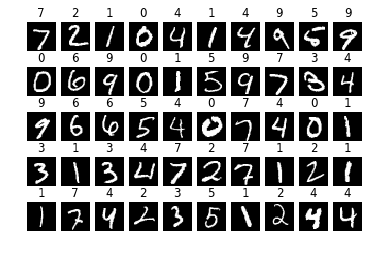

In [5]:
# Load the dataset:
import pickle, gzip
f = gzip.open('mnist.pkl.gz','rb')
train_set, valid_set, test_set = pickle.load(f,encoding='unicode-escape')
f.close()
x_train,y_train=train_set[0],train_set[1]
x_valid,y_valid=valid_set[0],valid_set[1]
x_test,y_test=test_set[0],test_set[1]

# Examine the dataset:
print("Shape : ", x_train.shape,y_train.shape,x_test.shape,y_test.shape)
print("Max and min of x_train and y_train : ", np.min(x_train),np.max(x_train),np.min(y_train),np.max(y_train))
for i in range(50):
    subplot(5,10,i+1)
    imshow(x_test[i].reshape([28,28]),cmap='gray');
    title(str(y_test[i]));
    axis('off')
    
# Transform NumPy arrays to PyTorch tensors:
use_cuda=t.cuda.is_available()

X_train=t.from_numpy(x_train)
Y_train=t.from_numpy(y_train)
X_test=t.from_numpy(x_test)
Y_test=t.from_numpy(y_test)

if(use_cuda):
    X_train=X_train.cuda()
    Y_train=Y_train.cuda()
    X_test=X_test.cuda()
    Y_test=Y_test.cuda()

## Start Traning

In [6]:
# Here is the PyTorch net:

D_in,H,D_out=784,100,10

# Training the network:
model = t.nn.Sequential(
    t.nn.Linear(D_in, H),
    t.nn.BatchNorm1d(H),
    t.nn.ReLU(),
    #t.nn.Dropout(p=0.5),
    t.nn.Linear(H, H),
    t.nn.BatchNorm1d(H),
    t.nn.ReLU(),
    #t.nn.Dropout(p=0.5),
    t.nn.Linear(H, D_out),
    t.nn.Softmax()
)

loss_fn = t.nn.CrossEntropyLoss()
learning_rate = 1e-4
optimizer = t.optim.Adam(model.parameters(), lr=learning_rate) #https://pytorch.org/docs/stable/optim.html

if(use_cuda):
    model=model.cuda()
    loss_fn=loss_fn.cuda()
    

torch_dataset = Data.TensorDataset(X_train, Y_train)

loader = Data.DataLoader(
    dataset=torch_dataset,      # torch TensorDataset format
    batch_size=100,      # mini batch size
    shuffle=True,               # 要不要打乱数据 (打乱比较好)
#     num_workers=2,              # 多线程来读数据
)

steper = 0
for i in range(51):   # 训练所有!整套!数据 3 次
#     print("i : ", i, "\n")
#     steper += 1
    stop_number = 0
    for step, (batch_x,batch_y) in enumerate(loader):  # 每一步 loader 释放一小批数据用来学习
#         print("step : ", step, "\n")
        # 假设这里就是你训练的地方...
#         print("batch_x : ", batch_x, "\n")
#         print("batch_x.shape : ", batch_x.shape, "\n")
#         print("batch_y.shape : ", batch_y.shape, "\n")
        predict_y = model(batch_x)
#         print("step : ", step)
# #         print(Y_pred)

        loss = loss_fn(predict_y, batch_y)
    
        # Zero the gradients before running the backward pass.
        model.zero_grad()

        # Backward pass:
        loss.backward()

        # Update the weights using gradient descent:
        optimizer.step()
    
        # Check training accuracy:
#         print(steper)
        if (steper % 500 == 0):
            predict_y = model(batch_x) # Y_pred.shape=[50000,10]
            predict_y = t.max(predict_y,1)[1] # Y_pred.shape=[50000]
            print('epoch ',int(steper/50),':',(predict_y==batch_y).sum().item()/batch_y.shape[0])
#             print(type((predict_y==batch_y).sum().item()/batch_y.shape[0]))
            stop_number = (predict_y==batch_y).sum().item()/batch_y.shape[0]
        steper += 1
    if (stop_number >= 0.98):
        break

/Users/Kuan-Hao/anaconda3/lib/python3.6/site-packages/torch/nn/modules/container.py:91: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


epoch  0 : 0.12
epoch  10 : 0.75
epoch  20 : 0.95
epoch  30 : 0.95
epoch  40 : 0.98
